## Простой эксперимент

### Вводные данные

Ограничения Telegram Bot API

In [88]:
MAX_REQUEST_PER_SECOND = 30
MAX_MESSAGES_IN_CHAT_PER_MINUTE = 20

Число переходов в бот с рекламы в час. Минимум, максимум.

In [89]:
MIN_CLICKS_PER_HOUR = 800
MAX_CLICKS_PER_HOUR = 1200

Время старта рекламы

In [90]:
import datetime as dt
import pytz

MSK = pytz.timezone('Europe/Moscow')

AD_START_TIME = dt.datetime(2021, 11, 10, 12, tzinfo=MSK)
AD_START_TIME.isoformat()

'2021-11-10T12:00:00+02:30'

Количество рекламных дней.

In [91]:
AD_TOTAL_DAYS = 5
AD_ACTIVE_HOURS_PER_DAY = 24

Вероятность, что на любом шаге клиент закроет бота и больше не вернется.

In [92]:
EXIT_PROBABILITY = .001
f'С вероятностью {EXIT_PROBABILITY:.1%} клиент уйдет с данного шага'

'С вероятностью 0.1% клиент уйдет с данного шага'

Сколько взаимодействий клиент сделает в боте в среднем. Сколько времени между двумя взаимодействиями в среднем. Шум.

In [93]:
MAX_STEPS = 50
MIN_SECONDS_BETWEEN_STEPS = 5
MAX_SECONDS_BETWEEN_STEPS = 60 * 60  # 60 minutes
MEAN_SECONDS_BETWEEN_STEPS = 60  # 60 seconds
STD_SECONDS_BETWEEN_STEPS = 30  # 30 seconds

### Симуляция

In [94]:
import pandas as pd
import random

requests = []
total_clients = 0
for day in range(AD_TOTAL_DAYS):
    for hour in range(AD_ACTIVE_HOURS_PER_DAY):
        clicks_in_this_hour = random.uniform(MIN_CLICKS_PER_HOUR, MAX_CLICKS_PER_HOUR)
        start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour)
        for click_no in range(int(clicks_in_this_hour)):
            client_id = f'{day}:{hour}:{click_no}'
            total_clients += 1
            start_time = AD_START_TIME + dt.timedelta(days=day, hours=hour + random.uniform(0, 1))
            request_time = start_time
            for step in range(MAX_STEPS):
                requests.append({
                    'time': request_time,
                    'client': client_id,
                })
                client_leaves_now = random.uniform(0, 1) <= EXIT_PROBABILITY
                if client_leaves_now:
                    break

                request_time += dt.timedelta(seconds=max(.0, random.gauss(MEAN_SECONDS_BETWEEN_STEPS, STD_SECONDS_BETWEEN_STEPS)))

In [95]:
requests_df = pd.DataFrame.from_records(requests, index='time')

In [96]:
requests_df.head()

,client
time,
2021-11-10 12:37:00.030460+03:00,0:0:0
2021-11-10 12:38:04.011999+03:00,0:0:0
2021-11-10 12:39:04.992183+03:00,0:0:0
2021-11-10 12:39:48.959445+03:00,0:0:0
2021-11-10 12:41:23.510351+03:00,0:0:0


### Результаты

In [97]:
s = pd.Series(1, requests_df.index, name='requests')
s.sort_index(inplace=True)
s = s.resample('S').sum()
s.head()

time
2021-11-10 12:30:04+03:00    1
2021-11-10 12:30:05+03:00    1
2021-11-10 12:30:06+03:00    1
2021-11-10 12:30:07+03:00    0
2021-11-10 12:30:08+03:00    0
Freq: S, Name: requests, dtype: int64

<AxesSubplot:xlabel='time'>

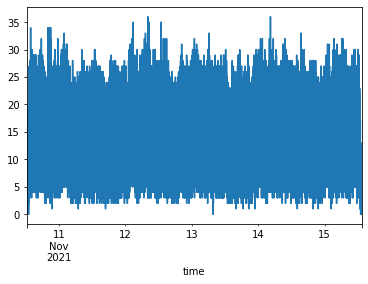

In [98]:
s.plot()

In [99]:
print(
    'Статистика:\n\n'
    'Запросов в секунду:\n'
    f'  Максимум: {s.max()}\n'
    f'  Минимум: {s.min()}\n'
    f'  В среднем: {s.mean():.2f}\n\n'
    f'Всего клиентов: {total_clients}\n'
    f'Рекламных дней: {AD_TOTAL_DAYS}\n'
    f'Рекламных дней: {AD_TOTAL_DAYS}\n'
)

Статистика:

Запросов в секунду:
  Максимум: 36
  Минимум: 0
  В среднем: 13.45

Всего клиентов: 120014


In [100]:

# total_clients